# RUMUSAN MASALAH
1. Apakah status tinggi air di pintu air atau curah hujan memprediksi banjir di wilayah tersebut?

2. Manakah yang lebih akurat untuk memprediksi banjir di suatu wilayah, status tinggi air di pintu air atau curah hujan?

# HIPOTESIS

1. Banjir dapat diprediksi berdasarkan status tinggi air di pintu air atau curah hujan di wilayah tersebut

2. Status tinggi air di pintu air lebih tepat digunakan untuk memprediksi banjir dibanding dengan data curah hujan  

# DATA YANG DIMILIKI
1. DATA KEJADIAN BANJIR TAHUN 2016-2020
2. DATA TINGGI AIR  TAHUN 2016-2020
3. CURAH HUJAN TAHUN 2016-2020

#Machine Learning
1. Machine Learning untuk memprediksi apakah banjir atau tidak di wilayah jakarta dengan fitur yang ada

2. Machine Learning untuk memprediksi berapa banyak jumlah banjir di tahun berikut nya







# LIBRARY

In [2]:
#Library Dataframe
import pandas as pd, numpy as np
#Library Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Library math

#hilangkan hashtag jika library belum terinstall
!pip install folium matplotlib mapclassify
!pip install geodatasets
!pip install catboost
import folium
from folium.plugins import TimeSliderChoropleth
from folium.plugins import TimestampedGeoJson
from geopy.geocoders import Nominatim

import re
import calendar

#sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
#
from statsmodels.tsa.seasonal import seasonal_decompose
#Hipotesis
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

#xgboost
import xgboost as xgb
#lightGBM
import lightgbm as lgb
#Catboost
from catboost import CatBoostClassifier

#tensor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00


# Data assessment & preprocessing

## Data Kejadian Banjir
Fitur yang tersedia sebagai berikut :
1. kota_administrasi
2. kecamatan
3. kelurahan
4. rw
5. jumlah_terdampak_rw
6. jumlah_terdampak_rt
7. jumlah_terdampak_kk
8. jumlah_terdampak_jiwa
9. ketinggian_air
10. tanggal_kejadian
11. lama_genangan
12. jumlah_meninggal
13. jumlah_hilang
14. jumlah_luka_berat
15. jumlah_luka_ringan
16. jumlah_pengungsi_tertinggi
17. jumlah_tempat_pengungsian
18. nilai_kerugian

Data diambil dari web https://data.jakarta.go.id/dataset?q=banjir dari tahun 2016-2020

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Baca File dan Gabung data (Merge)

In [8]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019,2020]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']
hari_list = ['01','02','03','04','05','06','07','08','09',
             '10','11','12','13','14','15','16','17','18',
             '19','20','21','22','23','24','25','26','27',
             '28','29','30','31']

In [9]:
#buat dataframe kosong
data_kejadian_banjir = pd.DataFrame()
#melakukan looping untuk tahun
for i in tahun_list:
  #melakukan looping untuk bulan
  for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-{i}-bulan-{str(bulan_list[j])}.csv'
      data = pd.read_csv(path)
    except: continue

    #menambahkan kolom tahun dan bulan
    data = data.assign(tahun=i,bulan=j+1)
    #menggabungkan data kedalam dataset data_kejadian_banjir
    data_kejadian_banjir = pd.concat([data_kejadian_banjir,data])

In [10]:
data_kejadian_banjir.sample(2)

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,jumlah_terdampak_rt,jumlah_terdampak_kk,jumlah_terdampak_jiwa,ketinggian_air,tanggal_kejadian,lama_genangan,jumlah_meninggal,jumlah_hilang,jumlah_luka_berat,jumlah_luka_ringan,jumlah_pengungsi_tertinggi,jumlah_tempat_pengungsian,nilai_kerugian,tahun,bulan
28,Jakarta Timur,JATINEGARA,BIDARA CINA,0,0.0,1.0,0.0,0.0,10 s/d 60 cm,2020-12-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12
10,Jakarta Timur,Jatinegara,Bidara Cina,"007, 011",2.0,2.0,0.0,0.0,10 - 20,"19, 20, 30",3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,1


In [11]:
data_kejadian_banjir.shape

(1623, 20)

In [12]:
#melihat info dataset
data_kejadian_banjir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 0 to 46
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   kota_administrasi           1571 non-null   object 
 1   kecamatan                   1571 non-null   object 
 2   kelurahan                   1571 non-null   object 
 3   rw                          1571 non-null   object 
 4   jumlah_terdampak_rw         1571 non-null   float64
 5   jumlah_terdampak_rt         1571 non-null   float64
 6   jumlah_terdampak_kk         1571 non-null   float64
 7   jumlah_terdampak_jiwa       1571 non-null   float64
 8   ketinggian_air              1571 non-null   object 
 9   tanggal_kejadian            1571 non-null   object 
 10  lama_genangan               1571 non-null   float64
 11  jumlah_meninggal            1571 non-null   float64
 12  jumlah_hilang               1571 non-null   float64
 13  jumlah_luka_berat           1571 no

### Cleaning Data

In [13]:
#Melihat nilai yang hilang pada dataset
data_kejadian_banjir.isna().sum()

kota_administrasi             52
kecamatan                     52
kelurahan                     52
rw                            52
jumlah_terdampak_rw           52
jumlah_terdampak_rt           52
jumlah_terdampak_kk           52
jumlah_terdampak_jiwa         52
ketinggian_air                52
tanggal_kejadian              52
lama_genangan                 52
jumlah_meninggal              52
jumlah_hilang                 52
jumlah_luka_berat             52
jumlah_luka_ringan            52
jumlah_pengungsi_tertinggi    52
jumlah_tempat_pengungsian     52
nilai_kerugian                52
tahun                          0
bulan                          0
dtype: int64

In [14]:
fitur = data_kejadian_banjir.columns
#merubah semua nilai pada data tipe string menjadi lowercase
for row in fitur:
  try:
    data_kejadian_banjir[row] = data_kejadian_banjir[row].str.lower()
  except: continue

In [15]:
#Menghilangkan nilai yang hilang pada dataset
data_kejadian_banjir = data_kejadian_banjir.dropna(subset=['kecamatan'])

In [16]:
#menambahkan kolom jumlah_banjir dalam sebulan
data_kejadian_banjir['jumlah_banjir'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: len(x.split(',')))

<ipython-input-16-ac5c783e32ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kejadian_banjir['jumlah_banjir'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: len(x.split(',')))


In [17]:
#menghilangkan string yang masih ada 'kec.'
data_kejadian_banjir['tanggal_kejadian'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: x.split('(')[0])

<ipython-input-17-c3e69dfe748d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kejadian_banjir['tanggal_kejadian'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: x.split('(')[0])


In [18]:
fitur_delete = ['jumlah_terdampak_rt','jumlah_terdampak_kk','jumlah_meninggal',
                'jumlah_hilang', 'jumlah_luka_berat',
                'jumlah_luka_ringan', 'jumlah_pengungsi_tertinggi',
                'jumlah_tempat_pengungsian', 'nilai_kerugian',
                'jumlah_terdampak_jiwa']
#menghapus kolom yang tidak di perlukan
data_kejadian_banjir = data_kejadian_banjir.drop(fitur_delete,axis=1)


In [19]:
data_kejadian_banjir.columns

Index(['kota_administrasi', 'kecamatan', 'kelurahan', 'rw',
       'jumlah_terdampak_rw', 'ketinggian_air', 'tanggal_kejadian',
       'lama_genangan', 'tahun', 'bulan', 'jumlah_banjir'],
      dtype='object')

In [20]:
data_kejadian_banjir.shape

(1571, 11)

In [21]:
data_kejadian_banjir['kota_administrasi'].unique()

array(['jakarta selatan', 'jakarta timur', 'jakarta barat',
       'jakarta utara', 'jakarta pusat', 'kepulauan seribu',
       'jakarta urata'], dtype=object)

In [22]:
data_kejadian_banjir.loc[data_kejadian_banjir['kota_administrasi'] == 'jakarta urata', 'kota_administrasi'] ='jakarta utara'

In [23]:
data_kejadian_banjir['kota_administrasi'].unique()

array(['jakarta selatan', 'jakarta timur', 'jakarta barat',
       'jakarta utara', 'jakarta pusat', 'kepulauan seribu'], dtype=object)

In [24]:
data_kejadian_banjir['kecamatan'].unique()

array(['kebayoran baru', 'kebayoran lama', 'pancoran', 'pasar minggu',
       'pesanggrahan', 'tebet', 'jatinegara', 'kramat jati', 'cengkareng',
       'grogol petamburan', 'kalideres', 'kebon jeruk', 'kembangan',
       'cilandak', 'jagakarsa', 'mampang prapatan', 'cakung', 'cipayung',
       'ciracas', 'makasar', 'pasar rebo', 'pulogadung', 'cilincing',
       'kelapa gading', 'koja', 'penjaringan', 'taman sari', 'pademangan',
       'gambir', 'kedoya selatan', 'duren sawit', 'jagakarta',
       'tanjung priok', 'kali deres', 'kemayoran', 'setia budi',
       'kec. cengkareng', 'kec. kembangan ', 'kec. palmerah',
       'kec. kebon jeruk', 'kec. cilandak', 'kec. mampang prapatan',
       'kec. jagakarsa', 'kec. pasar minggu', 'kec. kebayoran lama',
       'kec. cakung', 'kec. pasar rebo', 'kec. jatinegara',
       'kec. ciracas', 'kec. makasar', 'kec. kramat jati', 'makassar',
       'kec.kembangan', 'kec.kebayoran lama', 'kec.cilandak',
       'kec.kebayoran baru', 'cempaka putih',

In [25]:
#menghilangkan string yang masih ada 'kec. '
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].apply(lambda x: x.split('kec. ')[-1])
#menghilangkan string yang masih ada 'kec.'
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].apply(lambda x: x.split('kec.')[-1])
#menghilangkan spasi tambahan pada string
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].str.strip()
#kecamatan
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'makassar', 'kecamatan'] ='makasar'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'jagakarta', 'kecamatan'] ='jagakarsa'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'kali deres', 'kecamatan'] ='kalideres'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'mampang', 'kecamatan'] ='mampang prapatan'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'pulogadung', 'kecamatan'] ='pulo gadung'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'setia budi', 'kecamatan'] ='setiabudi'
#kota administrasi
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'cengkareng', 'kota_administrasi'] ='jakarta barat'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'kalideres', 'kota_administrasi'] ='jakarta barat'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'grogol petamburan', 'kota_administrasi'] ='jakarta barat'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'kembangan', 'kota_administrasi'] ='jakarta barat'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'kebon jeruk', 'kota_administrasi'] ='jakarta barat'
data_kejadian_banjir.loc[data_kejadian_banjir['kecamatan'] == 'penjaringan', 'kota_administrasi'] ='jakarta utara'

In [26]:
sorted(data_kejadian_banjir['kecamatan'].unique())

['cakung',
 'cempaka putih',
 'cengkareng',
 'cilandak',
 'cilincing',
 'cipayung',
 'ciracas',
 'duren sawit',
 'gambir',
 'grogol petamburan',
 'jagakarsa',
 'jatinegara',
 'johar baru',
 'kalideres',
 'kebayoran baru',
 'kebayoran lama',
 'kebon jeruk',
 'kedoya selatan',
 'kelapa gading',
 'kemayoran',
 'kembangan',
 'kepulauan seribu selatan',
 'kepulauan seribu utara',
 'koja',
 'kramat jati',
 'makasar',
 'mampang prapatan',
 'matraman',
 'pademangan',
 'palmerah',
 'pancoran',
 'pasar minggu',
 'pasar rebo',
 'penjaringan',
 'pesanggrahan',
 'pulo gadung',
 'sawah besar',
 'senen',
 'setiabudi',
 'taman sari',
 'tambora',
 'tanah abang',
 'tanjung priok',
 'tebet']

In [27]:
data_kejadian_banjir['kelurahan'].unique()

array(['cipete utara', 'petogogan', 'rawa barat', 'cipulir',
       'pondok pinang', 'rawajati', 'pejaten timur', 'ulujami',
       'bukit duri', 'kebon baru', 'bidara cina', 'kampung melayu',
       'cawang', 'cengkareng barat', 'cengkareng timur', 'duri kosambi',
       'kapuk', 'kedaung kali angke', 'rawa buaya', 'wijaya kesuma',
       'kalideres', 'kamal', 'pegadungan', 'tegal alur', 'kedoya utara',
       'kelapa dua', 'joglo', 'kembangan utara', 'meruya utara',
       'srengseng', 'cilandak barat', 'lebak bulus', 'pondok labu',
       'ciganjur', 'jagakarsa', 'lenteng agung', 'srengseng sawah',
       'grogol utara', 'bangka', 'pela mampang', 'kalibata', 'pengadegan',
       'kebagusan', 'cakung barat', 'cakung timur', 'jatinegara',
       'rawa terate', 'cilangkap', 'pondok ranggon', 'cibubur', 'ciracas',
       'kelapa dua wetan', 'rambutan', 'cipinang muara', 'bale kambang',
       'batu ampar', 'cililitan', 'dukuh', 'cipinang melayu',
       'halim perdana kusuma', 'kebon pa

In [28]:
#menghilangkan string yang masih ada 'kel. '
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel. ')[-1])
#menghilangkan string yang masih ada 'kel.'
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel.')[-1])
#menghilangkan string yang masih ada 'kel '
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel ')[-1])
#menghilangkan spasi tambahan pada string
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].str.strip()
#menghilangkan string 0
data_kejadian_banjir = data_kejadian_banjir[data_kejadian_banjir['kelurahan'] != '0']


In [29]:
#mengganti nilai yang salah
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'pengadengan', 'kelurahan'] ='pengadegan'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'rambuta', 'kelurahan'] ='rambutan'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'pulo', 'kelurahan'] ='pulo gadung'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'makasar', 'kelurahan'] ='makassar'

In [30]:
data_kejadian_banjir['kelurahan'].unique()

array(['cipete utara', 'petogogan', 'rawa barat', 'cipulir',
       'pondok pinang', 'rawajati', 'pejaten timur', 'ulujami',
       'bukit duri', 'kebon baru', 'bidara cina', 'kampung melayu',
       'cawang', 'cengkareng barat', 'cengkareng timur', 'duri kosambi',
       'kapuk', 'kedaung kali angke', 'rawa buaya', 'wijaya kesuma',
       'kalideres', 'kamal', 'pegadungan', 'tegal alur', 'kedoya utara',
       'kelapa dua', 'joglo', 'kembangan utara', 'meruya utara',
       'srengseng', 'cilandak barat', 'lebak bulus', 'pondok labu',
       'ciganjur', 'jagakarsa', 'lenteng agung', 'srengseng sawah',
       'grogol utara', 'bangka', 'pela mampang', 'kalibata', 'pengadegan',
       'kebagusan', 'cakung barat', 'cakung timur', 'jatinegara',
       'rawa terate', 'cilangkap', 'pondok ranggon', 'cibubur', 'ciracas',
       'kelapa dua wetan', 'rambutan', 'cipinang muara', 'bale kambang',
       'batu ampar', 'cililitan', 'dukuh', 'cipinang melayu',
       'halim perdana kusuma', 'kebon pa

In [31]:
data_kejadian_banjir.sample()

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,ketinggian_air,tanggal_kejadian,lama_genangan,tahun,bulan,jumlah_banjir
174,jakarta selatan,kebayoran lama,cipulir,0,0.0,20 cm,18 oktober,0.0,2020,11,1


In [32]:
data_kejadian_banjir.shape

(1570, 11)

### simpan data dalam format csv

In [33]:
data_kejadian_banjir.to_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_kejadian_banjir.csv', index=False)

## Data Tinggi Air
Fitur yang tersedia sebagai berikut :
1. tahun
2. bulan
3. nama_pintu_air
4. lokasi
5. latitude
6. longitude
7. rata rata tinggi_air
8. status_siaga

data di ambil dari web https://data.jakarta.go.id/dataset?q=banjir

### baca File dan Gabung data (Merge)

In [34]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019,2020]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']

In [35]:
#buat dataframe kosong
data_tinggi_air = pd.DataFrame()
#melakukan looping untuk tahun
for i in tahun_list:
  #melakukan looping untuk bulan
  for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-tinggi-muka-air-{str(bulan_list[j])}-{i}.csv'
      data = pd.read_csv(path)
    except: continue
    data = data.dropna(subset=['tanggal'])
    try:
      data = data[~data['tanggal'].str.contains('0000')]
    except:continue
    data['tanggal'] = pd.to_datetime(data['tanggal'])
    #menambahkan kolom tahun
    data['tahun'] = data['tanggal'].dt.year
    #menambahkan kolom bulan
    data['bulan'] = data['tanggal'].dt.month
    data['hari'] = data['tanggal'].dt.day
    #menggabungkan data kedalam dataset data_kejadian_banjir
    data_tinggi_air = pd.concat([data_tinggi_air,data]).reset_index(drop=True)

data_tinggi_air['tanggal'] = pd.to_datetime(data_tinggi_air['tahun'].astype(str) + '-' + data_tinggi_air['bulan'].astype(str) + '-' + data_tinggi_air['hari'].astype(str))
data_tinggi_air['tinggi_air'] = data_tinggi_air['tinggi_air']/10

<ipython-input-35-242c2e3aed33>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tanggal'] = pd.to_datetime(data['tanggal'])
<ipython-input-35-242c2e3aed33>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tahun'] = data['tanggal'].dt.year
<ipython-input-35-242c2e3aed33>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [36]:
data_tinggi_air.sample()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,waktu
1328292,Pompa Pasar Ikan,Laut,-6.126132,106.809783,2019-04-13,145.0,Status : Normal,2019,4,13,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_tinggi_air.shape

(1879498, 16)

### Cleaning Data

In [38]:
print(data_tinggi_air[' '].unique())
print(data_tinggi_air['Unnamed: 7'].unique())
print(data_tinggi_air['Unnamed: 8'].unique())
print(data_tinggi_air['Unnamed: 9'].unique())

[nan ' ']
[nan]
[nan ' ']
[nan '  ']


In [39]:
#Menghapus fitur yang tidak perlu
data_tinggi_air.drop([' ','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],axis=1,inplace=True)

In [40]:
data_tinggi_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879498 entries, 0 to 1879497
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   nama_pintu_air  object        
 1   lokasi          object        
 2   latitude        float64       
 3   longitude       float64       
 4   tanggal         datetime64[ns]
 5   tinggi_air      float64       
 6   status_siaga    object        
 7   tahun           int64         
 8   bulan           int64         
 9   hari            int64         
 10  Unnamed: 10     object        
 11  waktu           object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 172.1+ MB


In [41]:
data_tinggi_air.duplicated().sum()

1443697

In [42]:
data_tinggi_air.sample(5)

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
1521218,PS. Depok,Ciliwung,-6.400514,106.832143,2019-10-01,75.0,Status : Normal,2019,10,1,NaN,NaN
1359099,P.A. Pluit,Waduk Pluit,-6.109076,106.796649,2019-05-13,-175.0,Status : Normal,2019,5,13,NaN,NaN
1815773,Pompa Yos Sudarso 1,Sunter Timur,-6.155547,106.885975,2020-11-22,12.0,Status : Normal,2020,11,22,NaN,NaN
191928,PS. Cipinang Hulu,Cipinang Hulu,-6.374264,106.883862,2017-04-05,129.0,Normal,2017,4,5,NaN,NaN
1657143,PS. Pesanggrahan,Pesanggrahan,-6.397111,106.771825,2020-05-06,84.0,Status : Normal,2020,5,6,NaN,NaN


In [43]:
#Menghapus nilai duplikat pada dataset
data_tinggi_air = data_tinggi_air.drop_duplicates()


In [44]:
#melihat jumlah nilai yang hilang
data_tinggi_air.isna().sum()

nama_pintu_air         0
lokasi                 0
latitude            4543
longitude           4543
tanggal                0
tinggi_air           571
status_siaga           0
tahun                  0
bulan                  0
hari                   0
Unnamed: 10       435801
waktu             356113
dtype: int64

In [45]:
#drop data yang hilang pada fitur tinggi air
data_tinggi_air = data_tinggi_air.dropna(subset=['tinggi_air'])

In [46]:
data_tinggi_air['nama_pintu_air'].unique()

array(['PS. Depok', 'P.A. Karet', 'P.A Cideng - Siantar',
       'PS. Krukut Hulu', 'PS. Manggarai', 'PS. Kp. Melayu',
       'PS. Marunda', 'PS. Katulampa (Hulu)', 'PS. Cibogo',
       'P.A. Marina Ancol ', 'PA. Pasar Ikan (Laut)', 'PS. Cipinang Hulu',
       'P.A. Yos Sudarso 1', 'PA. Pulo Gadung', 'PS. Sunter Hulu',
       'PA. Tanjungan (Laut)', 'PA. Angke Hulu', 'PS. Pesanggrahan',
       'P.A. Pluit', 'PS. Marunda (LautP', 'PS. Marunda (Laut)',
       ' P.A Kali Duri (Kalijodo)', 'P.A. Jembatan Merah', 'P.A. Hek',
       'P.A. Istiqal  ', 'P.A. Ancol Flusing', 'PA. Manggarai',
       'Pompa Cideng', 'Pompa Pasar Ikan', 'Pompa Yos Sudarso 1',
       'Pompa Kali Duri (Kalijodo)', 'P.A. Istiqlal  ', 'PS. Angke Hulu',
       'Pompa Tanjungan', 'P.A Kali Duri (Kalijodo)', 'PA. Pasar Ikan',
       'PA. Tanjungan', 'PHB Tanjungan', 'PA. Cibalok - Gadog',
       'P.A. Flusing Ancol', 'Bendung. Cibalok - Gadog',
       'Bendung. Katulampa (Hulu)', 'Pompa. Pluit'], dtype=object)

In [47]:
drop_pintu_air = ['ps.pesang','PS. Depok','PS. Katulampa (Hulu)','PS. Katulampa (Hulu)',
                  'Bendung. Cibalok - Gadog','PS. Pesanggrahan','PS. Cipinang Hulu']

In [48]:
data_tinggi_air = data_tinggi_air[~data_tinggi_air['nama_pintu_air'].isin(drop_pintu_air)]

In [49]:
data_tinggi_air[(data_tinggi_air['tanggal'] > '2021-01-01') |((data_tinggi_air['tanggal'] < '2015-01-01')) ]

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
201202,PS. Marunda,Banjir Kanal Timur,-6.108719,106.969067,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204603,PS. Cibogo,Ciliwung,-6.657083,106.878083,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204606,PS. Kp. Melayu,Ciliwung,-6.225753,106.864228,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204607,PS. Manggarai,Ciliwung,-6.207825,106.848458,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204608,PS. Krukut Hulu,Krukut,-6.343900,106.798874,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204609,P.A Cideng - Siantar,Krukut,-6.173271,106.806351,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204610,P.A. Karet,Banjir Kanal Barat,-6.197901,106.810075,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204611,P.A. Marina Ancol,Laut,-6.125585,106.830154,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204612,PA. Pasar Ikan (Laut),Pasar Ikan,-6.126132,106.809783,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204613,P.A. Pluit,Waduk Pluit,-6.109076,106.796649,1970-01-01,0.0,Siaga 1,1970,1,1,NaN,NaN


In [50]:
drop_tahun = [1970,2021,2023,2032,2029]
data_tinggi_air = data_tinggi_air[~data_tinggi_air['tahun'].isin(drop_tahun)]

In [51]:
#Menggabungkan penamaan Status_siaga
data_tinggi_air['status_siaga'] = data_tinggi_air['status_siaga'].apply(lambda x: x.split(': ')[-1])

In [52]:
data_tinggi_air['status_siaga'].value_counts()

Normal     291276
Siaga 3     59112
Siaga 2     31407
Siaga 1      4207
Name: status_siaga, dtype: int64

In [53]:
fitur = data_tinggi_air.columns
#merubah semua nilai pada data tipe string menjadi lowercase
for row in fitur:
  try:
    data_tinggi_air[row] = data_tinggi_air[row].str.lower()
  except: continue

In [54]:
#data_tinggi_air = data_tinggi_air.groupby(['tanggal','tahun','bulan','hari','nama_pintu_air',
                                     # 'lokasi', 'latitude', 'longitude'],
                                      #    sort=False).agg({'tinggi_air': 'mean',
                                         #                  'status_siaga': lambda x: x.mode()[0]}).reset_index()

In [55]:
data_tinggi_air.head()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
1,p.a. karet,banjir kanal barat,-6.197901,106.810075,2016-11-25,371.0,normal,2016,11,25,NaN,NaN
2,p.a cideng - siantar,krukut,-6.173271,106.806351,2016-11-25,44.0,normal,2016,11,25,NaN,NaN
3,ps. krukut hulu,krukut,-6.343900,106.798874,2016-11-25,48.0,normal,2016,11,25,NaN,NaN
4,ps. manggarai,ciliwung,-6.207825,106.848458,2016-11-25,619.0,normal,2016,11,25,NaN,NaN
5,ps. kp. melayu,ciliwung,-6.225753,106.864228,2016-11-25,611.0,normal,2016,11,25,NaN,NaN


### simpan data dalam format csv

In [56]:
data_tinggi_air.to_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_tinggi_air.csv', index=False)

## Data Curah Hujan
Fitur yang tersedia sebagai berikut :
1. year
2. month
3. day
4. PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day)
5. TS              MERRA-2 Earth Skin Temperature (C)

Data di ambil dari web https://power.larc.nasa.gov/data-access-viewer/

### baca File dan Gabung data (Merge)

In [57]:
kota_list = ['jakarta barat','jakarta timur','jakarta selatan','jakarta pusat','jakarta utara']
#dataframe kosong
data_curah_hujan = pd.DataFrame()
#looping terhadap kota_list
for i in kota_list:
  #path adalah tempat data di simpan,
  #semua file di simpan di satu folder
  #gunakan nama yang sama kecuali kota nya
  path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/curah hujan/{i}_curah_hujan.csv'
  data = pd.read_csv(path,header=10)
  #ganti nama kolom
  data.columns = ['tahun','bulan','hari','suhu','curah_hujan']
  #menambahkan kolom nama kota
  data = data.assign(kota=i)
  #gabungkan data dengan data_curah_hujan
  data_curah_hujan = pd.concat([data_curah_hujan,data])

In [58]:
data_curah_hujan.sample(2)

,tahun,bulan,hari,suhu,curah_hujan,kota
199,2016,7,18,28.19,7.69,jakarta timur
1254,2019,6,8,28.47,9.27,jakarta pusat


In [59]:
data_curah_hujan.shape

(9135, 6)

In [60]:
data_curah_hujan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9135 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tahun        9135 non-null   int64  
 1   bulan        9135 non-null   int64  
 2   hari         9135 non-null   int64  
 3   suhu         9135 non-null   float64
 4   curah_hujan  9135 non-null   float64
 5   kota         9135 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 499.6+ KB


### Cleaning Data

In [61]:
#mengurutkan dari 2016 ke 2020
data_curah_hujan = data_curah_hujan.sort_values(by=['tahun','bulan','hari']).reset_index(drop=True)

In [62]:
#menambahkan format tanggal

data_curah_hujan['tanggal'] = pd.to_datetime(data_curah_hujan['tahun'].astype(str) + '-' + data_curah_hujan['bulan'].astype(str) + '-' + data_curah_hujan['hari'].astype(str))

In [63]:
data_curah_hujan.sample(2)

,tahun,bulan,hari,suhu,curah_hujan,kota,tanggal
6620,2019,8,17,27.01,0.31,jakarta barat,2019-08-17
4414,2018,6,1,28.30,0.25,jakarta utara,2018-06-01


### simpan data dalam format csv


In [64]:
data_curah_hujan.to_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_curah_hujan.csv', index=False)

# Exploratory Data Analysis (EDA)

1. data_kejadian_banjir

2. data_tinggi_air

3. data_curah_hujan

### Mencari Anomali

#### Data Tinggi Air

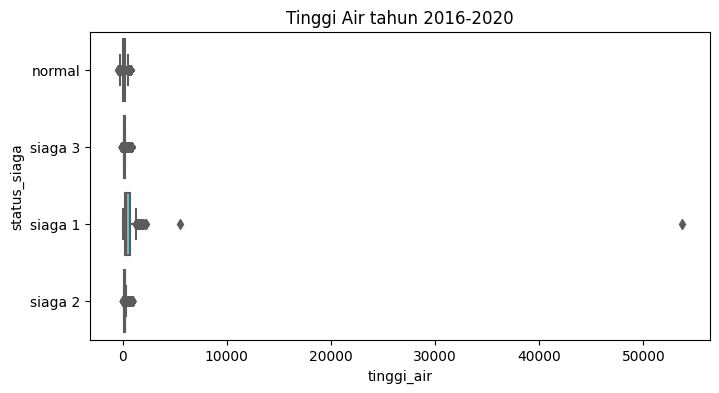

In [65]:
# Meliha anomali tinggi air
plt.figure(figsize=(8,4),frameon=True)
plt.title('Tinggi Air tahun 2016-2020')
sns.boxplot(data = data_tinggi_air,
            x='tinggi_air',
             y='status_siaga',
            palette='hls',)
plt.show()

In [66]:
data_tinggi_air.shape

(386002, 12)

In [67]:
# Fungsi untuk menghilangkan anomali/outlier
def outlier_tinggi_air(data,status):
  data_status = data[data['status_siaga'] == status]
  boxplot = plt.boxplot(data_status['tinggi_air'].values)
  plt.close()
  outliers = list(boxplot['fliers'][0].get_data()[1])
  data = data[~data["tinggi_air"].isin(outliers)]
  return data

In [68]:
status = ['normal','siaga 1','siaga 2','siaga 3']
for i in status:
  data_tinggi_air = outlier_tinggi_air(data_tinggi_air,i)

In [69]:
data_tinggi_air.shape

(297277, 12)

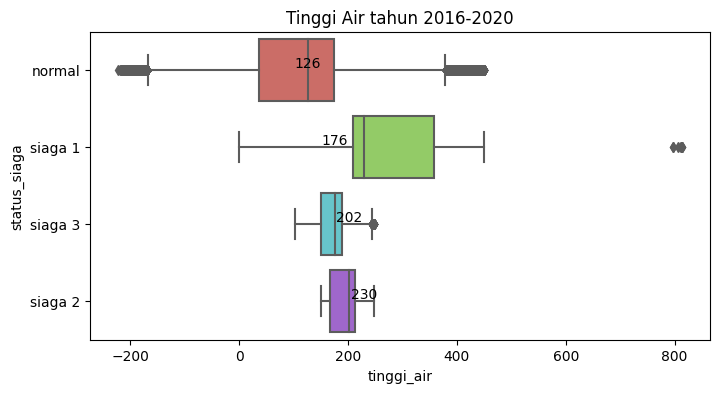

In [70]:
data = data_tinggi_air.groupby('status_siaga')['tinggi_air'].median().sort_values().values.astype(int)
plt.figure(figsize=(8,4),frameon=True)
plt.title('Tinggi Air tahun 2016-2020')
sns.boxplot(data = data_tinggi_air.sort_values(by='tinggi_air'),
            x='tinggi_air',
             y='status_siaga',
            palette='hls',)
for i in range(len(data)):
      plt.text(data[i],i,str(data[i]), ha='center', va='bottom')
plt.show()

### Grafik Sebaran Banjir Jakarta

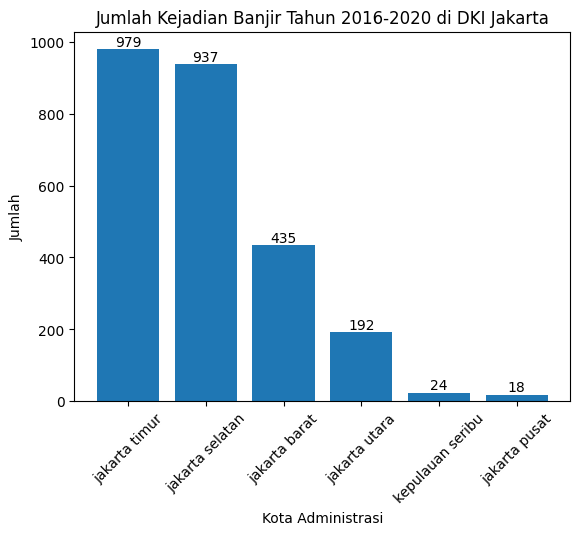

In [71]:
#Mengelompokan jumlah kejadian berdasarkan kota administrasi
data = data_kejadian_banjir.groupby('kota_administrasi')['jumlah_banjir'].sum().sort_values(ascending=False)

#Grafik Bar
plt.bar(data.index, data.values)

# Memberikan judul dan label pada sumbu
for i in range(len(data)):
    plt.text(i, data[i], str(data[i]), ha='center', va='bottom')
plt.title('Jumlah Kejadian Banjir Tahun 2016-2020 di DKI Jakarta')
plt.xlabel('Kota Administrasi')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

# Menampilkan grafik
plt.show()

#### Grafik sebaran banjir per kota administrasi

In [72]:
#Fungsi untuk memvisualisasikan data sebaran banjir per kecamatan
def grafik_kecamatan(kota,shift):
  data = data_kejadian_banjir[data_kejadian_banjir['kota_administrasi'] == kota].groupby(
      'kecamatan')['jumlah_banjir'].sum().sort_values(ascending=True)
  #Grafik Bar
  plt.barh(data.index, data.values)

  # Memberikan judul dan label pada sumbu
  for i in range(len(data)):
      plt.text(data[i]+shift,i-0.3,str(data[i]), ha='center', va='bottom')
  plt.title(f'Jumlah Kejadian Banjir Tahun 2016-2020 di {kota}')
  plt.xlabel('Jumlah')
  plt.ylabel('Kecamatan')

  # Menampilkan grafik
  plt.show()

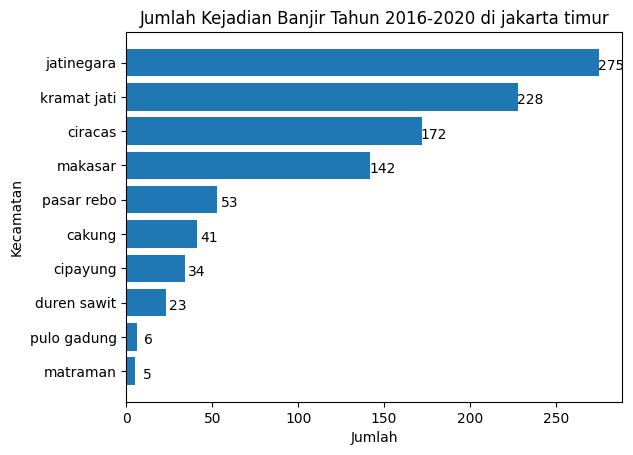

In [73]:
grafik_kecamatan('jakarta timur',7)

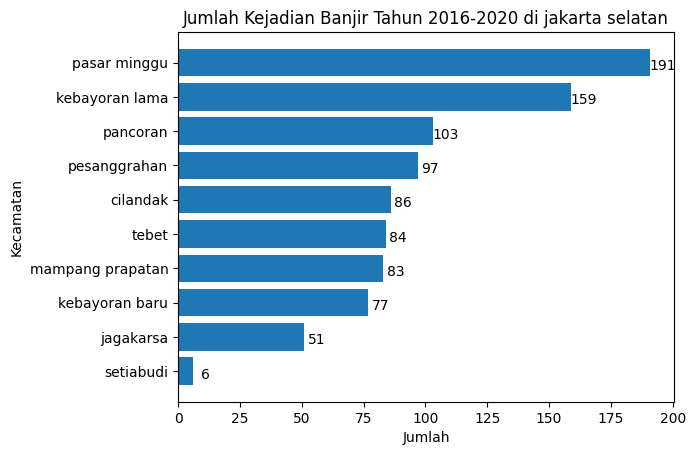

In [74]:
grafik_kecamatan('jakarta selatan',5)

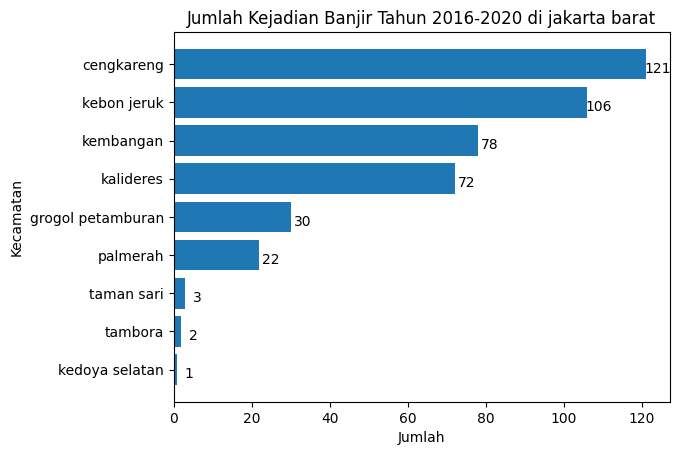

In [75]:
grafik_kecamatan('jakarta barat',3)

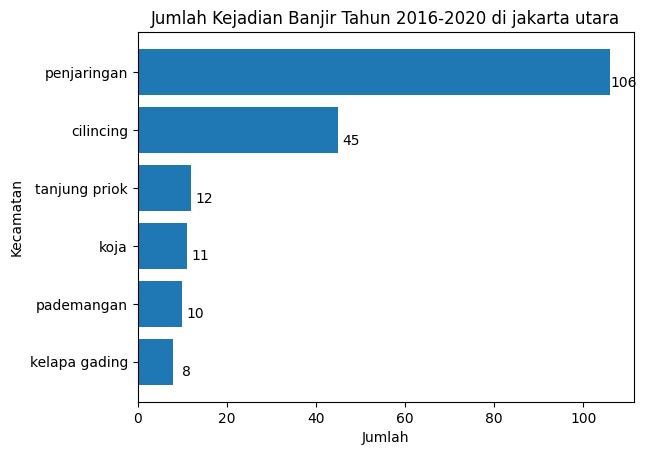

In [76]:
grafik_kecamatan('jakarta utara',3)

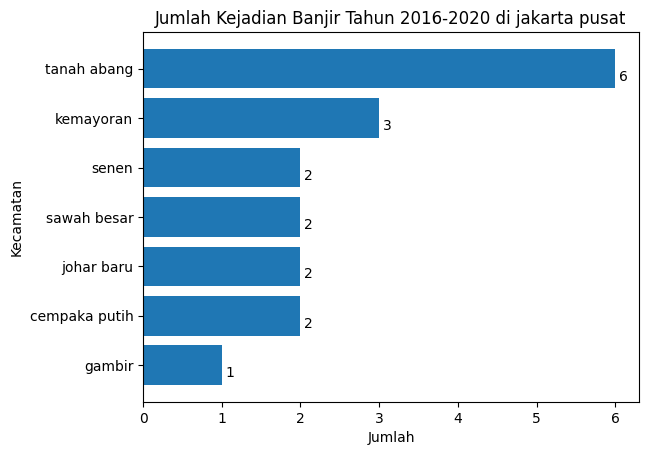

In [77]:
grafik_kecamatan('jakarta pusat',0.1)

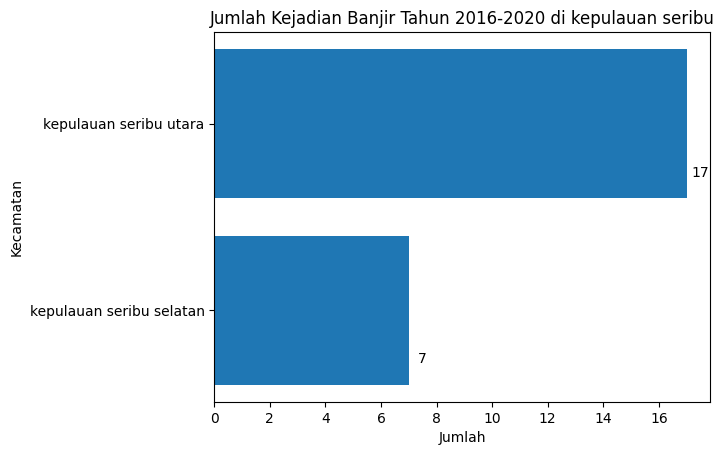

In [78]:
grafik_kecamatan('kepulauan seribu',0.5)

### Data curah Hujan

In [79]:
data_curah_hujan.sample()

,tahun,bulan,hari,suhu,curah_hujan,kota,tanggal
2109,2017,2,25,27.47,10.32,jakarta utara,2017-02-25


In [80]:
avg_data_curah_hujan = data_curah_hujan.groupby('tanggal')['curah_hujan'].mean().reset_index().set_index('tanggal')

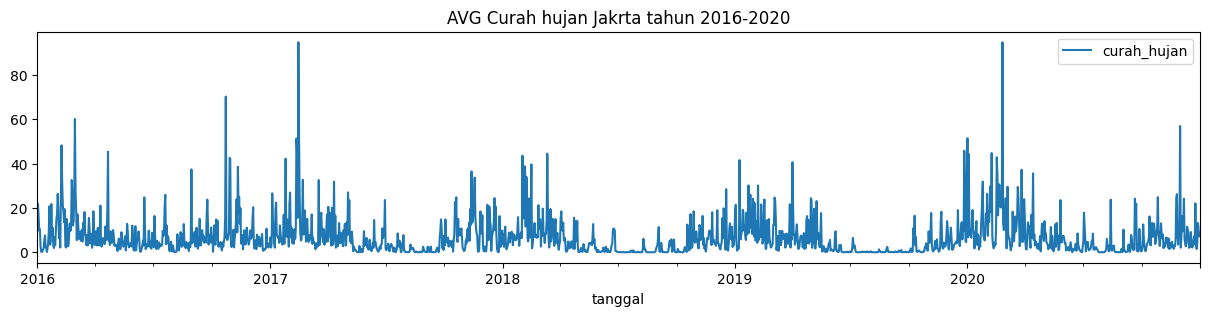

In [81]:
avg_data_curah_hujan.plot(figsize=(15,3))
plt.title('AVG Curah hujan Jakrta tahun 2016-2020')
plt.show()

In [82]:
decomposed = seasonal_decompose(avg_data_curah_hujan)

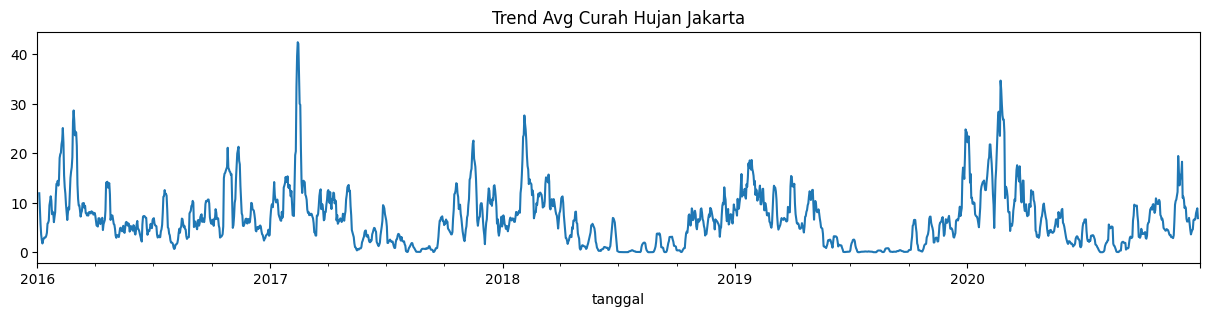

In [83]:
plt.figure(figsize=(15,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend Avg Curah Hujan Jakarta')
plt.show()

Insight : Adanya Kenaikan curah hujan di awal tahun dan mengalami penurunan di pertengahan tahun

# Geografis Jakarta
Note.
Dapat dilihat di Notebook terpisah yang dikirim berbarengan dengan notebook ini, dikarenakan jika dijadikan 1 notebook terlalu membebani compiler google colab kami,

# HIPOTESIS

1. Banjir dapat diprediksi berdasarkan status tinggi air di pintu air atau curah hujan di wilayah tersebut

2. Status tinggi air di pintu air lebih tepat digunakan untuk memprediksi banjir dibanding dengan data curah hujan

## Pengumpulan Data

### Data tinggi Air

In [84]:
#melihat minimal data dari quantile 0.25 dari status siaga
data_tinggi_air.groupby('status_siaga')['tinggi_air'].quantile(0.25)

status_siaga
normal      37.0
siaga 1    209.0
siaga 2    167.0
siaga 3    151.0
Name: tinggi_air, dtype: float64

In [85]:
#melakukan pengelompokan data berdasarkan tanggal dan rata rata dari tinggi air
daily_data_tinggi_air = data_tinggi_air.groupby('tanggal')['tinggi_air'].mean().reset_index()

In [86]:
#membuat fungsi untuk memberikan label pada tinggi air
def status(data):
  if data['tinggi_air'] <= 143:
    data['status'] = '0' #status normal
  elif data['tinggi_air'] <= 158:
    data['status'] = '3' #status siaga 3
  elif data['tinggi_air'] <= 229:
    data['status'] = '2' #status siaga 2
  else: data['status'] = '1' #status siaga 1
#data status diambil berdasarkan pantauan quantile 0.25

  return data

In [87]:
daily_data_tinggi_air = daily_data_tinggi_air.apply(status,axis=1)
daily_data_tinggi_air['status'].value_counts()

0    816
3    118
2     78
1      3
Name: status, dtype: int64

In [88]:
#membuat dataframe baru dari tanggal 1 januari 2016 sampai 31 desember 2020
start_date = '2016-01-01'
end_date = '2020-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
tinggi_air_2016_2020 = pd.DataFrame({'tanggal': date_range})

In [89]:
#menggabungkan dataset yang berisi tanggal 2016-2020 dengan data tinggi air yang di miliki berdasarkan tanggal
tinggi_air_2016_2020 = pd.merge(tinggi_air_2016_2020, daily_data_tinggi_air, on='tanggal',how='left')
tinggi_air_2016_2020['tahun'] = tinggi_air_2016_2020['tanggal'].dt.year
tinggi_air_2016_2020['bulan'] = tinggi_air_2016_2020['tanggal'].dt.month
tinggi_air_2016_2020['hari'] = tinggi_air_2016_2020['tanggal'].dt.day
#mengisi nilai yang hilang dengan 0
tinggi_air_2016_2020 = tinggi_air_2016_2020.fillna(0)

In [90]:
tinggi_air_2016_2020['status'].value_counts()

0    816
0    812
3    118
2     78
1      3
Name: status, dtype: int64

In [91]:
tinggi_air_2016_2020.shape

(1827, 6)

### Data Curah Hujan

In [92]:
data_curah_hujan.sample()

,tahun,bulan,hari,suhu,curah_hujan,kota,tanggal
3706,2018,1,11,27.48,9.76,jakarta timur,2018-01-11


In [93]:
#mengelompokan curah hujan di jakarta berdasarkan tanggal dan rata rata value
curah_hujan_2016_2020 = data_curah_hujan.groupby('tanggal')[['suhu','curah_hujan']].mean().reset_index()

In [94]:
merged_tinggi_air_dan_hujan = pd.merge(tinggi_air_2016_2020, curah_hujan_2016_2020, on='tanggal',how='left')

In [95]:
merged_tinggi_air_dan_hujan.sample()

,tanggal,tinggi_air,status,tahun,bulan,hari,suhu,curah_hujan
48,2016-02-18,0.0,0,2016,2,18,28.282,2.646


### Data Kejadian

In [96]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']
hari_list = ['01','02','03','04','05','06','07','08','09',
             '10','11','12','13','14','15','16','17','18',
             '19','20','21','22','23','24','25','26','27',
             '28','29','30','31']

In [97]:
data_banjir_2016_2020 = pd.DataFrame(columns=['jumlah banjir'])

#mengambil jumlah bajir setiap tanggal dari 2016 sampai 2019

#buat dataframe kosong
#melakukan looping untuk tahun
for i in tahun_list:
  for j in range(len(bulan_list)):
      try:
        #path adalah tempat data di simpan,
        #semua file di simpan di satu folder
        #gunakan nama yang sama kecuali tahun dan bulan nya
        path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-{i}-bulan-{str(bulan_list[j])}.csv'
        data = pd.read_csv(path)
      except:
        data = pd.DataFrame({'tanggal_kejadian': ['0'] * 31})
      data['tanggal_kejadian'] = data['tanggal_kejadian'].apply(lambda x: re.findall('([0-9]+)',str(x)))
      data = data['tanggal_kejadian'].apply(lambda x: ', '.join(x))
      data = data.str.split(',', expand=True).fillna(0).replace('','0').astype(int)
      jumlah_hari = calendar.monthrange(i, j+1)[1]
      jumlah_angka = data.values.flatten().tolist()
      angka_counts = pd.Series(jumlah_angka).value_counts().sort_index()
      angka_counts = angka_counts.reindex(range(1, jumlah_hari+1), fill_value=0)
      df_baru = pd.DataFrame({'jumlah banjir': angka_counts})
      data_banjir_2016_2020 = pd.concat([data_banjir_2016_2020, df_baru], ignore_index=True)

#mengambil jumlah bajir setiap tanggal tahun 2020
#melakukan looping untuk bulan
for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-2020-bulan-{str(bulan_list[j])}.csv'
      data = pd.read_csv(path)
    except:
      data = pd.DataFrame({'tanggal_kejadian': ['0'] * 31})
    data['tanggal_kejadian'] = data['tanggal_kejadian'].apply(lambda x: re.findall('([0-9]+)',str(x)))
    data = data['tanggal_kejadian'].apply(lambda x: ', '.join(x))
    data = data.str.split(',').str[-1].fillna(0).replace('','0').astype(int)
    jumlah_hari = calendar.monthrange(2020, j+1)[1]
    jumlah_angka = data.values.flatten().tolist()
    angka_counts = pd.Series(jumlah_angka).value_counts().sort_index()
    angka_counts = angka_counts.reindex(range(1, jumlah_hari+1), fill_value=0)
    df_baru = pd.DataFrame({'jumlah banjir': angka_counts})
    data_banjir_2016_2020 = pd.concat([data_banjir_2016_2020, df_baru], ignore_index=True)

#merubah tipe data jumlah banjir menjadi integer
data_banjir_2016_2020['jumlah banjir'] = data_banjir_2016_2020['jumlah banjir'].astype(int)


In [98]:
start_date = '2016-01-01'
end_date = '2020-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
data_banjir_2016_2020['tanggal'] = date_range


In [99]:
#membuat label banjir atau tidak , 1 berarti banjir 0 berarti tidak banjir di wilayah jakarta
data_banjir_2016_2020['banjir'] = data_banjir_2016_2020['jumlah banjir'].apply(lambda x: 1 if x != 0 else 0)

In [100]:
data_banjir_2016_2020.sample()

,jumlah banjir,tanggal,banjir
298,0,2016-10-25,0


### Data Full

In [101]:
#Menggabungkan data tinggi air dengan data banjir
data_full = pd.merge(merged_tinggi_air_dan_hujan,data_banjir_2016_2020,on='tanggal')

## Korelasi dari full data tahun 2016-2020

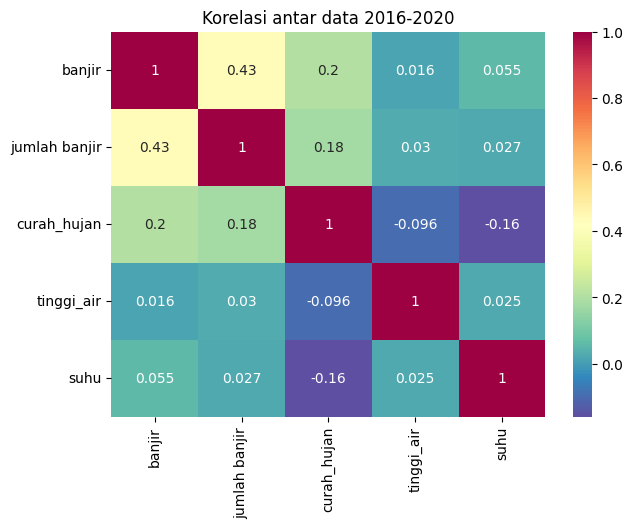

In [102]:
kolom_corr = ['banjir','jumlah banjir','curah_hujan','tinggi_air','suhu']
# Membuat matriks korelasi dengan heatmap
plt.figure(figsize=(7,5))
sns.heatmap(data_full[kolom_corr].corr(),
                annot=True,
                cmap='Spectral_r',
                linecolor='white')
plt.title('Korelasi antar data 2016-2020')
plt.show()

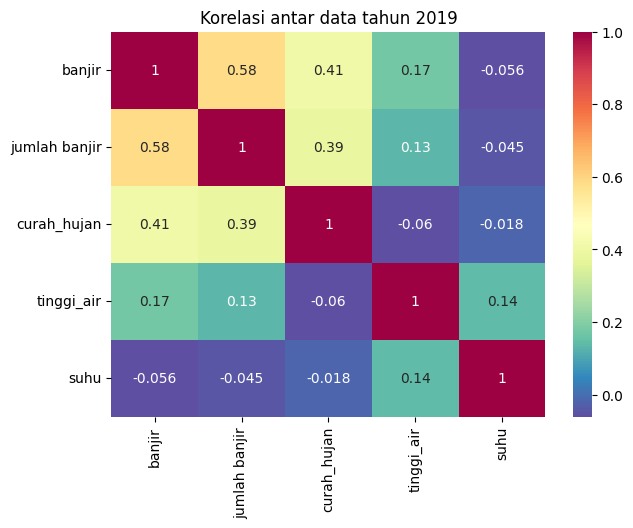

In [103]:
data_2019_2020 = data_full[data_full['tahun']==2019]
# Membuat matriks korelasi dengan heatmap
plt.figure(figsize=(7,5))
sns.heatmap(data_2019_2020[kolom_corr].corr(),
                annot=True,
                cmap='Spectral_r',
                linecolor='white')
plt.title('Korelasi antar data tahun 2019')
plt.show()

## Uji Hipotesis

### Uji Hipotesis 1
rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir adalah sama
1. **Hipotesis nol** = Tidak ada perbedaan rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir
2.**Hipotesis Alternatif** = Ada perbedaan rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir

In [104]:
#Memisahkan data yang bajir = 0 dan banjir =1
# Memisahkan data ke dalam dua kelompok
kelompok1_curah_hujan = data_full[data_full['banjir'] == 0]['curah_hujan']
kelompok2_curah_hujan = data_full[data_full['banjir'] == 1]['curah_hujan']

In [105]:
kelompok1_curah_hujan.mean()

5.742906017579445

In [106]:
kelompok2_curah_hujan.mean()

10.17205172413793

In [107]:

stat, p = ttest_ind(kelompok1_curah_hujan, kelompok2_curah_hujan)

# Menampilkan hasil uji hipotesis
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

stat=-8.884, p=0.000
Hipotesis nol ditolak


**hipotesis alternatif dapat diterima, sehingga dapat disimpulkan bahwa terdapat perbedaan rata-rata curah hujan yang signifikan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir.**

### Uji Hipotesis 2
Ada hubungan positif antara curah hujan dan risiko banjir. Semakin tinggi curah hujan, semakin tinggi risiko banjir.

1. Hipotesis nol: Tidak ada hubungan antara curah hujan dan risiko banjir.
2. Hipotesis alternatif: Ada hubungan antara curah hujan dan risiko banjir.

In [108]:
from scipy.stats import pearsonr
corr, p = pearsonr(data_full['curah_hujan'], data_full['banjir'])

# Menampilkan hasil uji hipotesis
print('Korelasi: %.3f' % corr)
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

Korelasi: 0.204
Hipotesis nol ditolak


dikarenakan Hipotesis nol ditolak maka hipotesis alternatif yang digunakan, maka dapat disimpulkan bahwa terdapat hubungan positif yang lemah antara curah hujan dan risiko banjir.

### Uji Hipotesis 3
1. Hipotesis nol: Tidak ada perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.
2. Hipotesis alternatif: Terdapat perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.

In [109]:
#Memisahkan data yang bajir = 0 dan banjir =1
# Memisahkan data ke dalam dua kelompok
kelompok1_tinggi_air = data_full[data_full['banjir'] == 0]['tinggi_air']
kelompok2_tinggi_air = data_full[data_full['banjir'] == 1]['tinggi_air']

In [110]:
stat, p = ttest_ind(kelompok1_tinggi_air, kelompok2_tinggi_air)

# Menampilkan hasil uji hipotesis
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

stat=-0.665, p=0.506
Tidak cukup bukti untuk menolak hipotesis nol


**Dengan hasil yang didapat, tidak cukup bukti untuk menolak hipotesis nol, sehingga tidak dapat disimpulkan adanya perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir berdasarkan data yang ada.**

### Uji Hipotesis 4

1. Hipotesis nol: Tidak ada perbedaan tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.
2. Hipotesis alternatif: Terdapat perbedaan tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.

In [111]:
# Membuat tabel kontingensi antara tinggi air pada pintu air dan kejadian banjir
table = pd.crosstab(data_full['tinggi_air'], data_full['banjir'])

# Melakukan uji chi-square untuk melihat hubungan antara tinggi air pada pintu air dan kejadian banjir
stat, p, dof, expected = chi2_contingency(table)

# Menampilkan hasil uji hipotesis
print('Statistik: %.3f' % stat)
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

Statistik: 967.013
Tidak cukup bukti untuk menolak hipotesis nol


**Dengan hasil yang didapat, tidak cukup bukti untuk menolak hipotesis nol, sehingga tidak dapat disimpulkan adanya perbedaan antara dua kelompok yang diuji berdasarkan data yang ada.**

#Modeling Machine Learning

data menggunakan dataset data_full

FItur :
  1. tinggi_air
  2. status
  3. bulan
  4. hari
  5. curah hujan

target
  1. banjir

In [112]:
data_full.sample()

,tanggal,tinggi_air,status,tahun,bulan,hari,suhu,curah_hujan,jumlah banjir,banjir
1284,2019-07-08,84.726115,0,2019,7,8,26.948,2.958,0,0


In [113]:
#drop kolom yang tidak di butuhkan
data_ml = data_full.drop(columns=['tahun','jumlah banjir'],axis=1). set_index('tanggal')

In [114]:
data_ml['status'] = data_ml['status'].astype(int)

In [115]:
data_ml.head()

,tinggi_air,status,bulan,hari,suhu,curah_hujan,banjir
tanggal,,,,,,,
2016-01-01,0.0,0,1,1,27.738,21.840,0
2016-01-02,0.0,0,1,2,27.514,21.936,1
2016-01-03,0.0,0,1,3,27.906,16.228,1
2016-01-04,0.0,0,1,4,27.938,9.628,0
2016-01-05,0.0,0,1,5,27.904,10.376,0


In [116]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tinggi_air   1827 non-null   float64
 1   status       1827 non-null   int64  
 2   bulan        1827 non-null   int64  
 3   hari         1827 non-null   int64  
 4   suhu         1827 non-null   float64
 5   curah_hujan  1827 non-null   float64
 6   banjir       1827 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 114.2 KB


## data untuk model

In [117]:
#Fungsi untuk membuat data train di upsample
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345
    )

    return X_upsampled, y_upsampled

In [118]:
#Fungsi untuk membuat data train di downsample
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)]
        + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)]
        + [y_ones])

    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)

    return X_downsampled, y_downsampled


In [119]:
#Memisahkan data fitur dan target
X = data_ml.drop(columns='banjir',axis=1)
y = data_ml['banjir']

In [120]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tinggi_air   1827 non-null   float64
 1   status       1827 non-null   int64  
 2   bulan        1827 non-null   int64  
 3   hari         1827 non-null   int64  
 4   suhu         1827 non-null   float64
 5   curah_hujan  1827 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 99.9 KB


## Split Data

In [121]:
# Split data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'jumlah ukuran X_train {X_train.shape}')
print(f'jumlah ukuran X_test {X_test.shape}')
print(f'jumlah ukuran y_train {y_train.shape}')
print(f'jumlah ukuran y_test {y_test.shape}')

jumlah ukuran X_train (1552, 6)
jumlah ukuran X_test (275, 6)
jumlah ukuran y_train (1552,)
jumlah ukuran y_test (275,)


In [122]:
def evaluate_model(models,data, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    start_time = time.time()
    #Data
    train_features = X_train
    train_target = y_train
    test_features = X_test
    test_target = y_test

    #Data jika Upsample/Downsample
    if data == 'upsample':
      train_features, train_target = upsample(X_train, y_train, 4)
    if data == 'downsample':
      train_features, train_target = downsample(X_train, y_train, 0.4)

    # Membuat model
    model = models
    # Melatih model
    model.fit(train_features, train_target)

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Accuracy
        acc = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['Accuracy'] = acc

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Kurva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(4)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    # Menampilkan hasil
    execution_time = time.time() - start_time
    #Menambahkan hasil ke datasets results dan menyimpan nya dalam bentuk csv
    list_result = [[str(models)[0:10],data,
              df_eval_stats['test'][0],df_eval_stats['test'][1],df_eval_stats['test'][3],
              execution_time]]
    result = pd.DataFrame(list_result,columns=[['model','data','accuracy','f1_score','auc_roc','execution_time']])
    result.to_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/hasil_ml_predict.csv', mode='a', header=False, index=False)

    print(df_eval_stats)
    return

## Model memprediksi banjir atau tidak berdasarkan fitur

Metrik utama adalah akurasi,
metrik tambahan F1 score, PRC dan ROC AUC


Target dari metrik akurasi adalah mendapatkan hasil di atas 0.8

### Sklearn

#### Random Forest

          train    test
Accuracy    1.0  0.8255
F1          1.0  0.2727
APS         1.0  0.4256
ROC AUC     1.0  0.7987


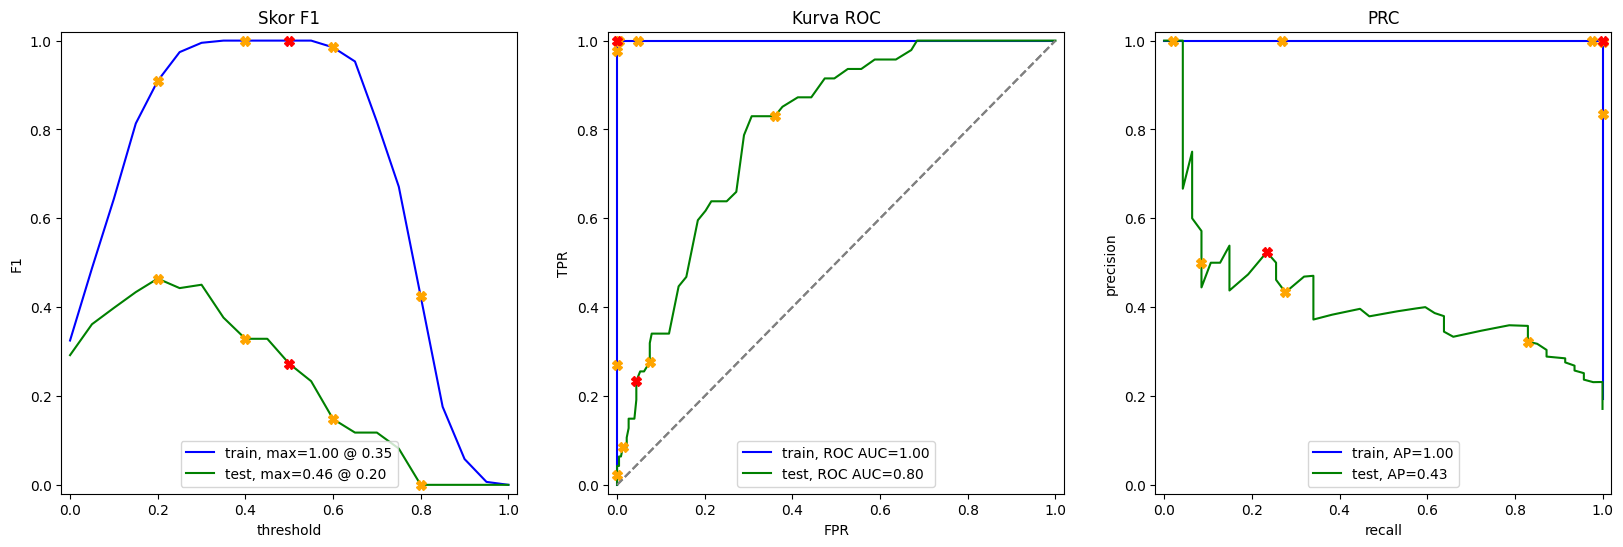

In [123]:
evaluate_model(RandomForestClassifier(),'None')

#### Linear Regression

           train    test
Accuracy  0.6517  0.8182
F1        0.3586  0.2647
APS       0.5220  0.4305
ROC AUC   0.6922  0.8007


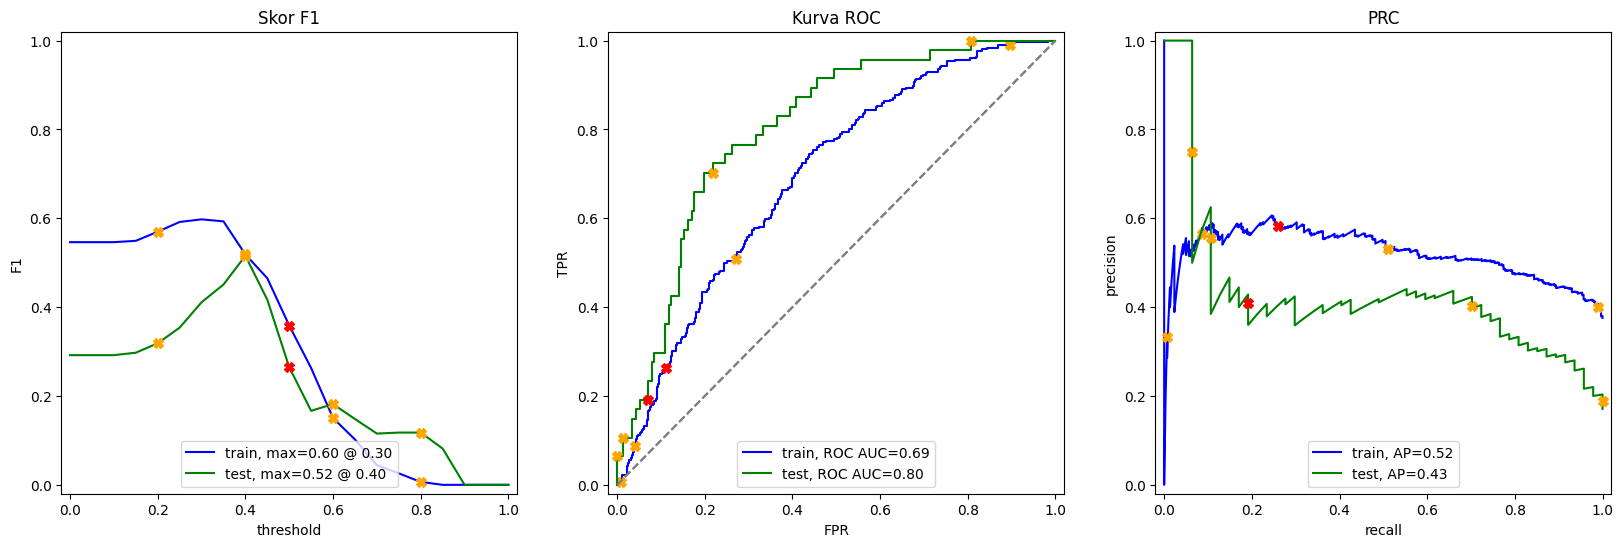

In [124]:
evaluate_model(LogisticRegression(random_state=12345),'downsample')

#### Decission Tree

           train    test
Accuracy  0.8505  0.8109
F1        0.3990  0.1613
APS       0.6047  0.2575
ROC AUC   0.8566  0.6598


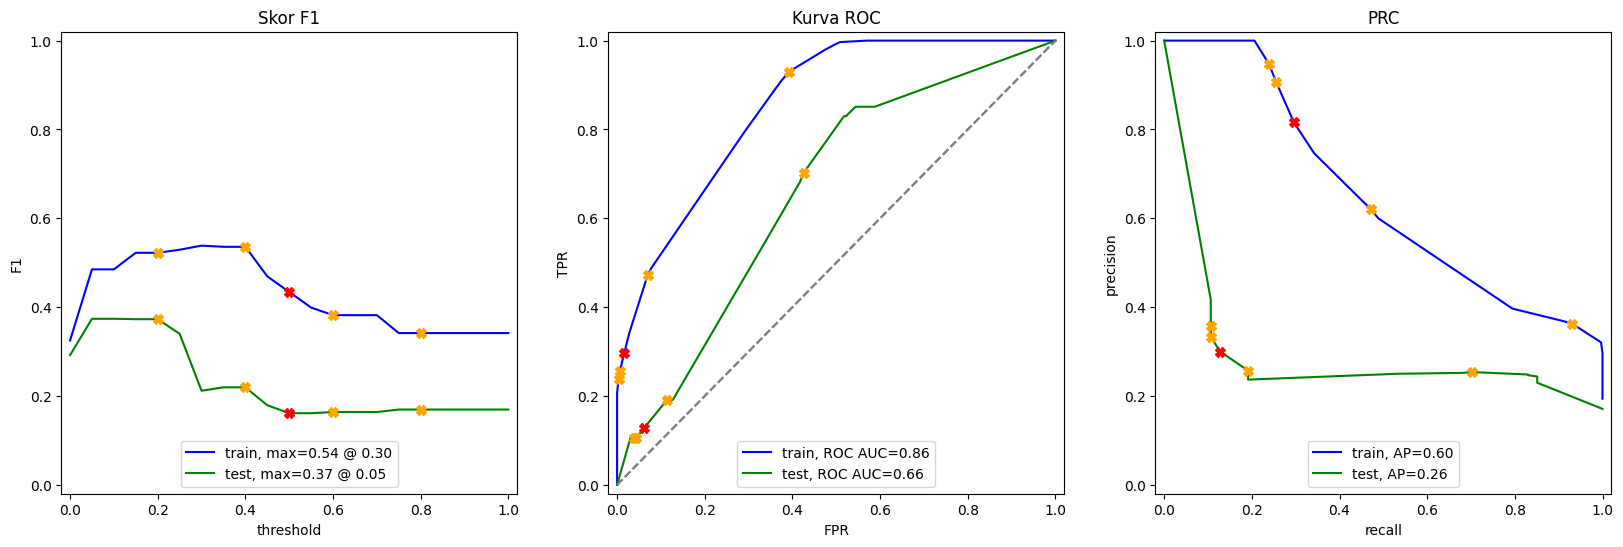

In [125]:
evaluate_model(DecisionTreeClassifier(random_state=12345,max_depth=8),'None')

#### GradientBoosting

           train    test
Accuracy  0.9530  0.8145
F1        0.8620  0.1905
APS       0.9873  0.3601
ROC AUC   0.9964  0.7563


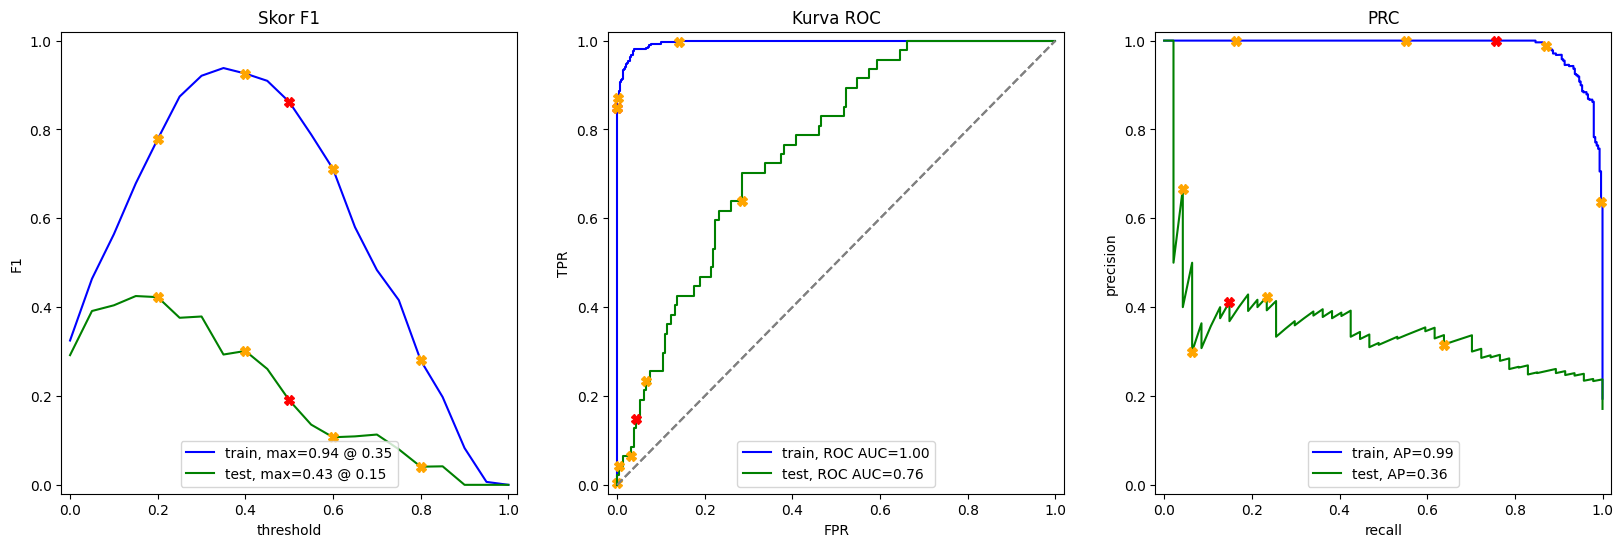

In [126]:
evaluate_model(GradientBoostingClassifier(random_state=12345,max_depth=5),'None')

#### SVC

           train    test
Accuracy  0.8061  0.8291
F1        0.0000  0.0000
APS       0.3625  0.3171
ROC AUC   0.6698  0.6485


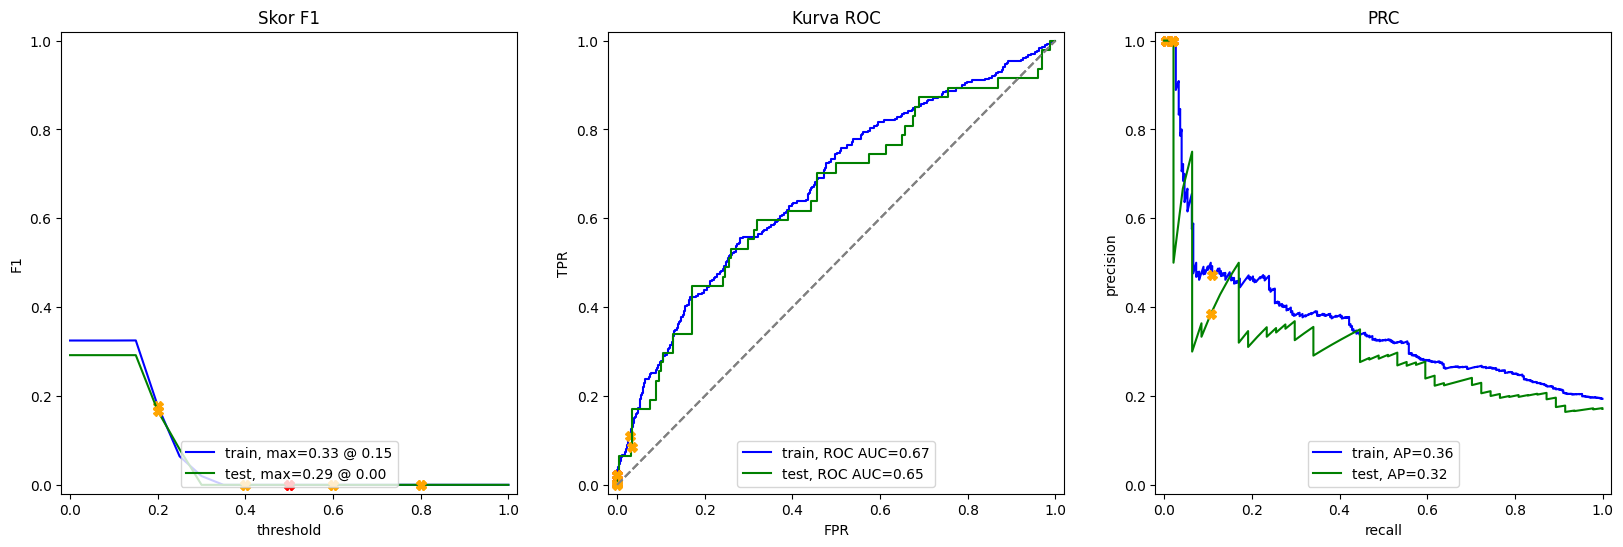

In [127]:
evaluate_model(SVC(probability=True,random_state=12345),'None')

#### KNN

           train    test
Accuracy  0.8241  0.7891
F1        0.4026  0.1944
APS       0.5233  0.2824
ROC AUC   0.8581  0.6784


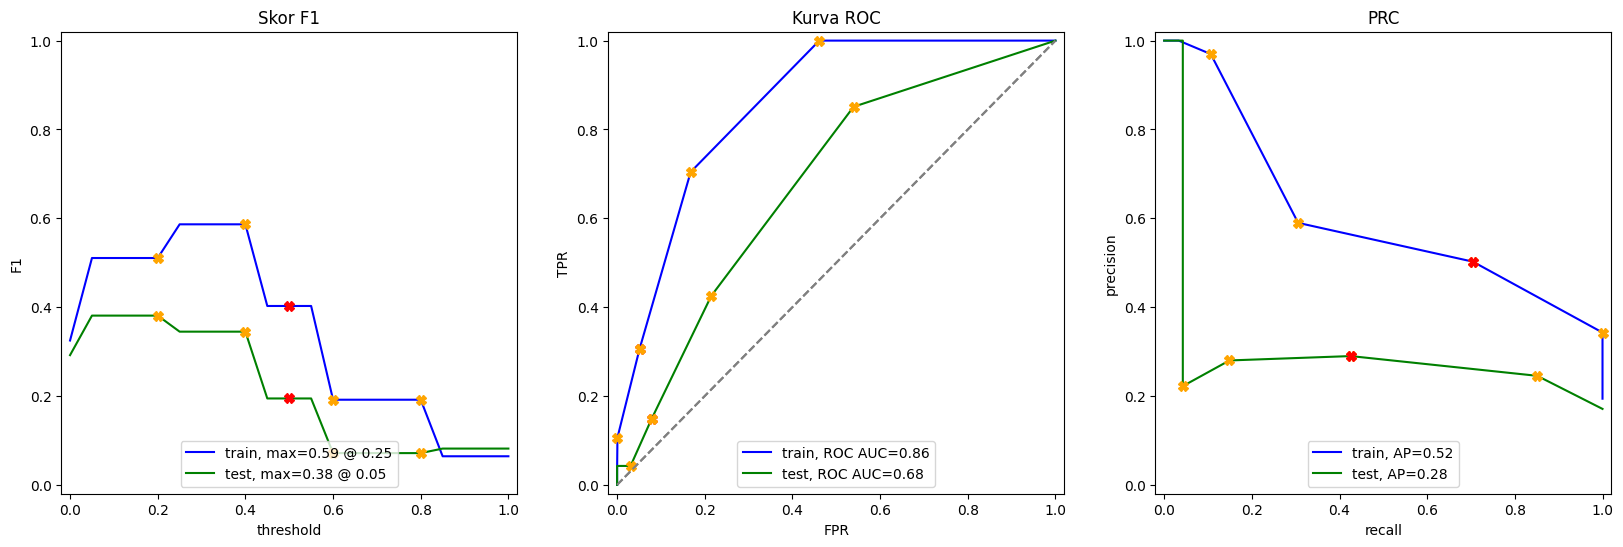

In [128]:
evaluate_model(KNeighborsClassifier(),'None')

### XGBoost

           train    test
Accuracy  0.8473  0.8255
F1        0.3612  0.1429
APS       0.7663  0.4218
ROC AUC   0.9239  0.7858


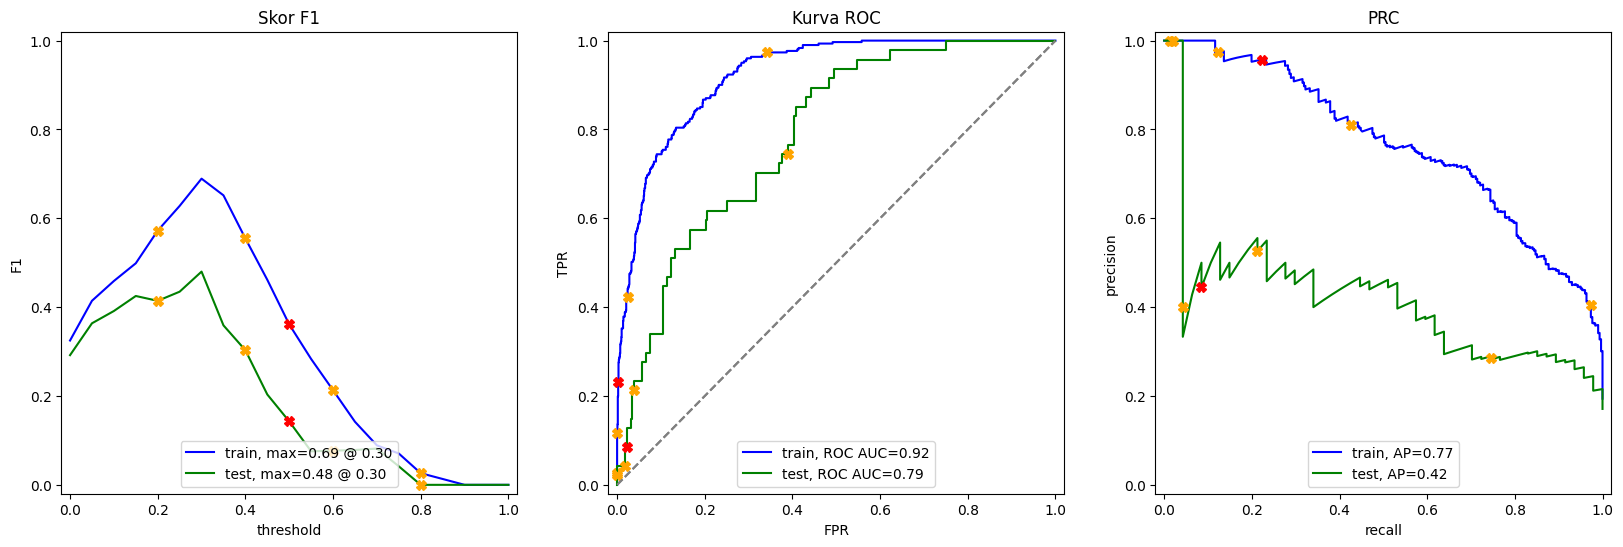

In [129]:
evaluate_model(xgb.XGBClassifier(max_depth=5,learning_rate=0.05),'None')

### LGBM

           train    test
Accuracy  0.8486  0.8291
F1        0.4391  0.2034
APS       0.6651  0.3852
ROC AUC   0.8744  0.7708


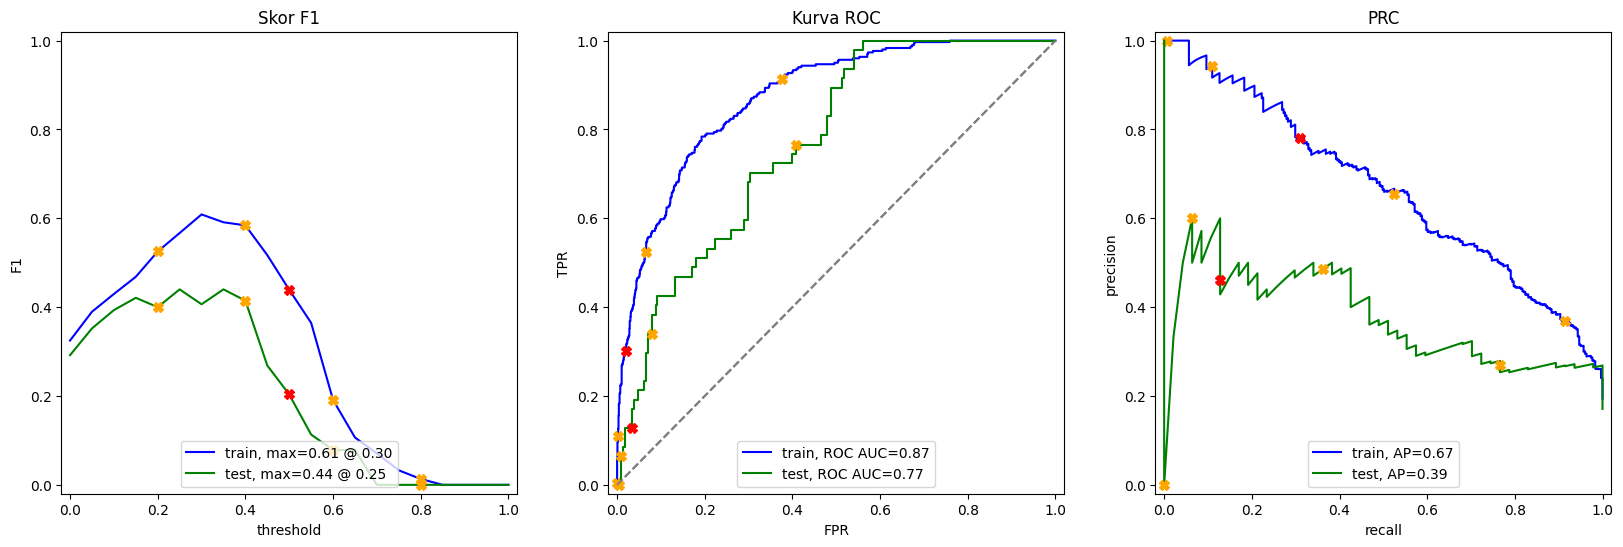

In [130]:
evaluate_model(lgb.LGBMClassifier(boosting_type='goss',learning_rate=0.04,num_leaves=10,random_state=12345),'None')

### Catboost

           train    test
Accuracy  0.8396  0.8364
F1        0.3102  0.1818
APS       0.6477  0.4642
ROC AUC   0.8566  0.8120


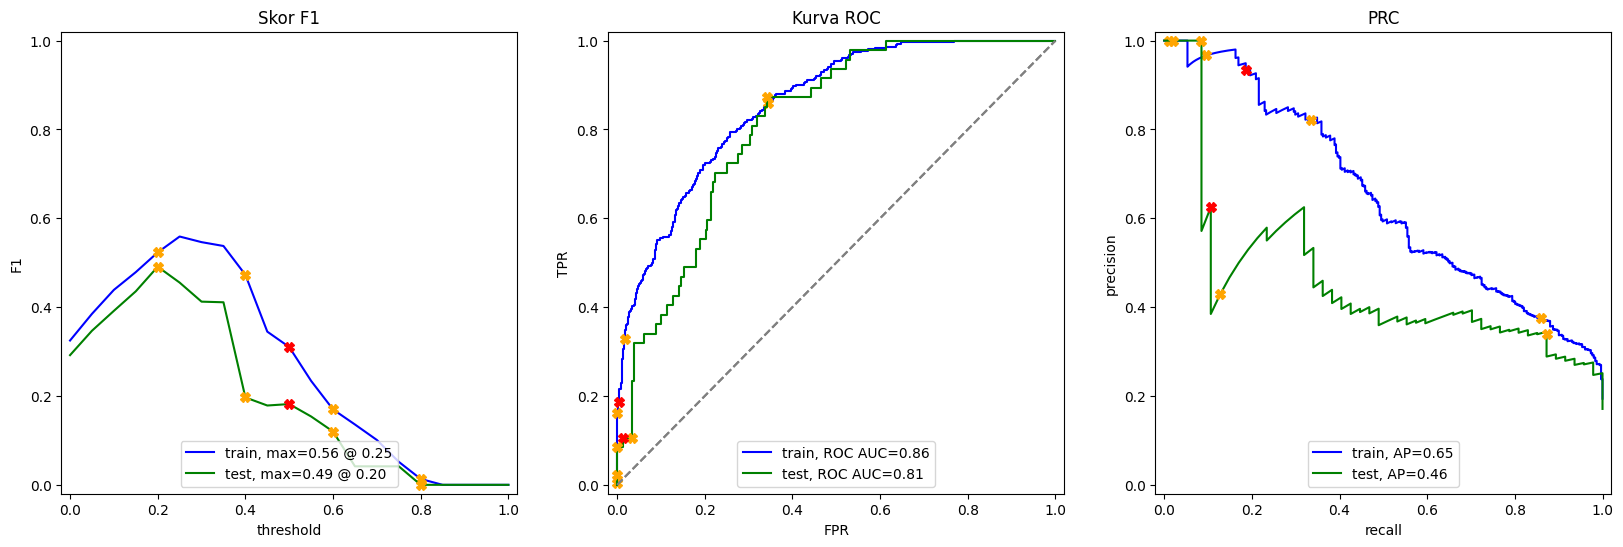

In [131]:
evaluate_model(CatBoostClassifier(random_state=12345,learning_rate=0.008,depth=4,verbose=0),'None')

### Neural Network

In [132]:
from tensorflow import keras
# Melakukan standarisasi fitur
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Membangun model Neural Network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.005)
# Mengompilasi model
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

# Melatih model
model.fit(X_train_scale, y_train, epochs=8, verbose=0,validation_data=(X_test_scale, y_test))

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Akurasi Model: %.3f' % test_acc)

9/9 [==============================] - 0s 3ms/step - loss: 4.2169 - accuracy: 0.8291
Akurasi Model: 0.829


## Hasil dari akurasi setiap model

In [143]:
result_ml = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/hasil_ml_predict.csv')

In [144]:
result_ml.sort_values(by='accuracy',ascending=False).head()

,model,data,accuracy,f1_score,auc_roc,execution_time
0,RandomFore,None,0.8400,0.3333,0.8171,0.687993
8,<catboost.,None,0.8364,0.1818,0.8120,1.553396
17,<catboost.,None,0.8364,0.1818,0.8120,3.091059
4,SVC(probab,None,0.8291,0.0000,0.6485,1.047919
7,LGBMClassi,None,0.8291,0.2034,0.7708,0.294192


In [145]:
result_ml = result_ml[['model','accuracy']].sort_values(by='accuracy',ascending=False).groupby('model')['accuracy'].max().reset_index()

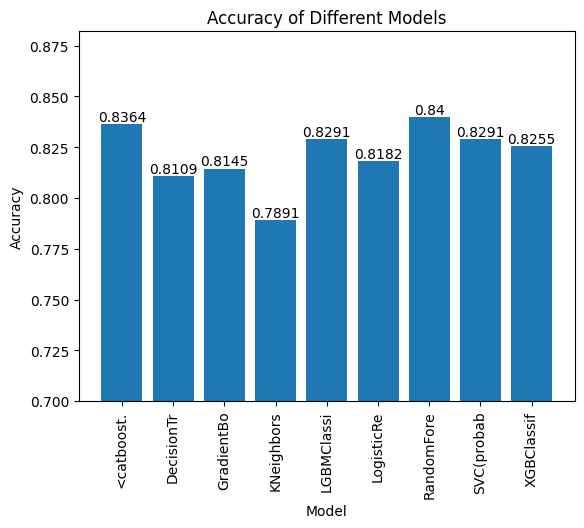

In [147]:
# Create a bar plot
plt.bar(result_ml['model'], result_ml['accuracy'])

# Customize the plot
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7)
plt.title('Accuracy of Different Models')
plt.xticks(rotation=90)

for i in range(len(result_ml['model'])):
    plt.text(i, result_ml['accuracy'][i], str(result_ml['accuracy'][i]), ha='center', va='bottom')

# Display the plot
plt.show()

#Kesimpulan

Kesimpulan Penelitian Tentang Kejadian Banjir di Wilayah Jakarta

Kami menggunakan empat jenis data yang berbeda, yaitu data data curah hujan, data kejadian banjir, data tinggi air di sungai dan data geografi. Namun, Kami menghadapi beberapa kesulitan dalam proses preprocessing data karena adanya fitur dan nilai yang tidak standar, berubah-ubah, dan tidak konsisten.

Setelah melakukan Exploratory Data Analysis (EDA), kami membuat grafik yang menunjukkan jumlah kejadian banjir di kecamatan wilayah Jakarta. Selain itu, kami juga melakukan pemeriksaan anomali terhadap data tinggi air dan rata-rata curah hujan.

Selanjutnya, kami melakukan Uji Hipotesis dengan menguji hipotesis rata-rata dua populasi. Hasil uji hipotesis menunjukkan bahwa hipotesis ditolak, yang berarti ada perbedaan signifikan antara kedua populasi yang diuji. Selain itu, hasil analisis juga menunjukkan bahwa tidak ada korelasi yang signifikan antara kejadian banjir dengan data lainnya, kecuali korelasi antara curah hujan dan kejadian banjir yang memiliki korelasi sebesar 0.2.

Setelah melakukan penelitian dan eksplorasi data, Kami melanjutkan dengan pembuatan model untuk memprediksi apakah akan terjadi banjir di wilayah Jakarta pada tanggal-tanggal tertentu. Berbagai model telah dicoba dan hasilnya menunjukkan bahwa akurasi maksimal yang dapat dicapai adalah sebesar 0.83.

Meskipun akurasi model tersebut cukup tinggi, Kami menyadari bahwa diperlukan perbaikan dan pengembangan lebih lanjut dalam upaya meningkatkan akurasi prediksi. Model yang digunakan dapat dievaluasi lebih lanjut dengan menggunakan tambahan variabel yang lebih signifikan terhdapat banjir. Selain itu, bisa juga dilakukan pemilihan model yang lebih kompleks atau pengolahan data yang lebih cermat untuk meningkatkan performa model.

Penting untuk diingat bahwa tidak hanya akurasi yang perlu dipertimbangkan dalam evaluasi model. Faktor lain seperti kepekaan terhadap false positives atau false negatives juga harus dipertimbangkan. Oleh karena itu perlu dilakukan lebih banyak penelitian dan eksperimen untuk memperbaiki model dan meningkatkan performanya agar dapat memberikan prediksi yang lebih akurat dan dapat diandalkan dalam memitigasi risiko banjir di wilayah Jakarta.
